In [5]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib


In [35]:
#load data
app_data = pd.read_csv("C:/Users/lap/Downloads/application_record.csv")
credit_data = pd.read_csv("C:/Users/lap/Downloads/credit_record.csv")

print("Application Record shape:", app_data.shape)
print("Credit Record shape:", credit_data.shape)

Application Record shape: (438557, 18)
Credit Record shape: (1048575, 3)


In [37]:
# Preprocessing
app_data.drop_duplicates(subset='ID', inplace=True)

categorical_cols = app_data.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    app_data[col] = le.fit_transform(app_data[col])

credit_data['STATUS'] = credit_data['STATUS'].replace(['C', 'X'], '0')
credit_data['STATUS'] = credit_data['STATUS'].astype(int)
credit_status = credit_data.groupby('ID')['STATUS'].max().reset_index()
credit_status['Approved'] = credit_status['STATUS'].apply(lambda x: 0 if x > 1 else 1)
credit_status.drop('STATUS', axis=1, inplace=True)

# Merge and Finalize Dataset
data = pd.merge(app_data, credit_status, on='ID')
data.drop('ID', axis=1, inplace=True)

print("Final dataset shape:", data.shape)

# Feature Scaling & Splitting
X = data.drop('Approved', axis=1)
y = data['Approved']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


Final dataset shape: (36457, 18)


In [27]:
# Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [29]:
# Model Evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.13      0.19       123
           1       0.99      1.00      0.99      7169

    accuracy                           0.98      7292
   macro avg       0.67      0.56      0.59      7292
weighted avg       0.97      0.98      0.98      7292

Confusion Matrix:
 [[  16  107]
 [  30 7139]]
ROC-AUC Score: 0.7882714306289388


In [31]:
# Save Model
joblib.dump(model, 'credit_card_approval_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

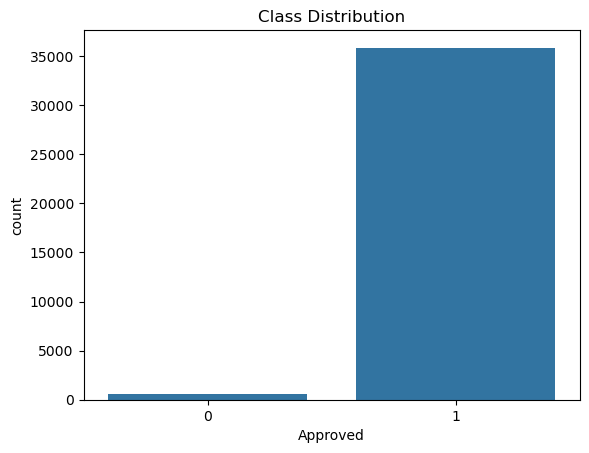

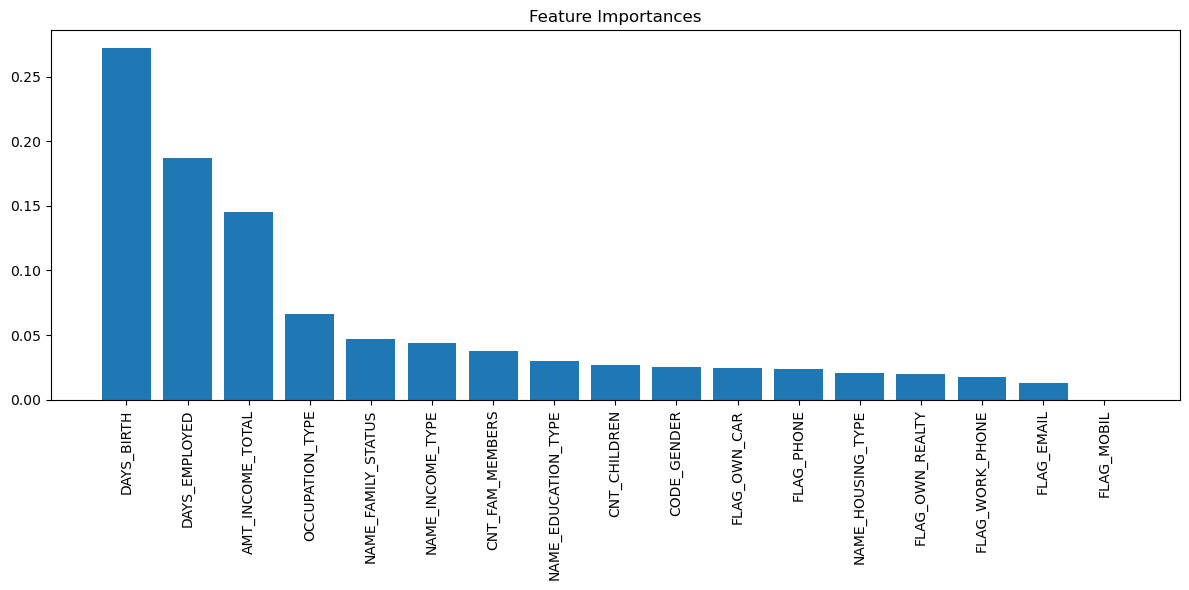

In [33]:
# Visualizations
sns.countplot(x='Approved', data=data)
plt.title("Class Distribution")
plt.show()

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(12,6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()